# 이미지 전처리 및 Data Augmentation

In [19]:
import os
import glob
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models

from config import path

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
device

device(type='cpu')

In [7]:
def display_images_center_crop(image_paths, title, max_images=4):
    plt.figure(figsize=(12, 3))
    for i, image_path in enumerate(image_paths[:max_images]):
        image = Image.open(image_path)
        width, height = image.size

        new_edge_length = min(width, height)
        left = (width - new_edge_length)/2
        top = (height - new_edge_length)/2
        right = (width + new_edge_length)/2
        bottom = (height + new_edge_length)/2

        image_cropped = image.crop((10, 20, width-10, height-15))

        plt.subplot(1, max_images, i+1)
        plt.imshow(image_cropped)
        plt.title(title)
        plt.axis('off')
    plt.show()

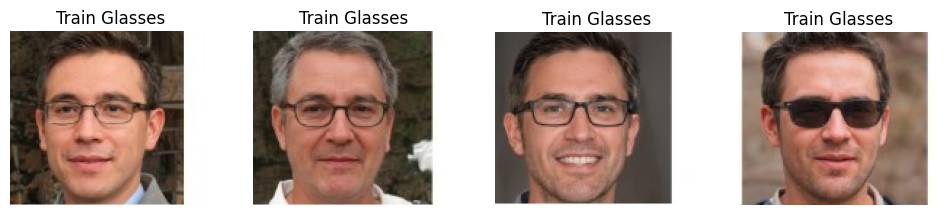

Train Glasses 총 이미지 수: 52


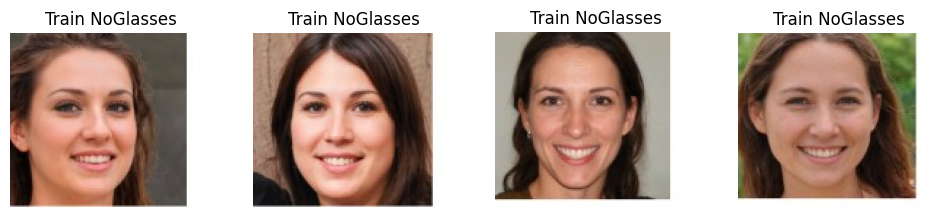

Train NoGlasses 총 이미지 수: 52


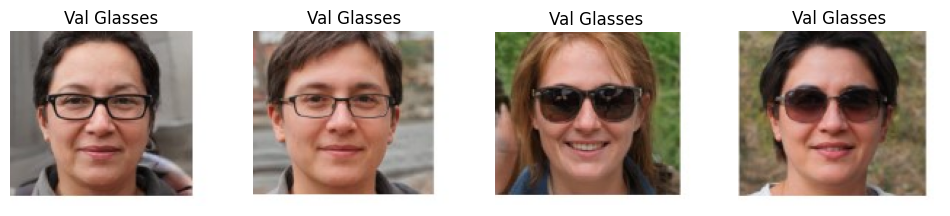

Val Glasses 총 이미지 수: 20


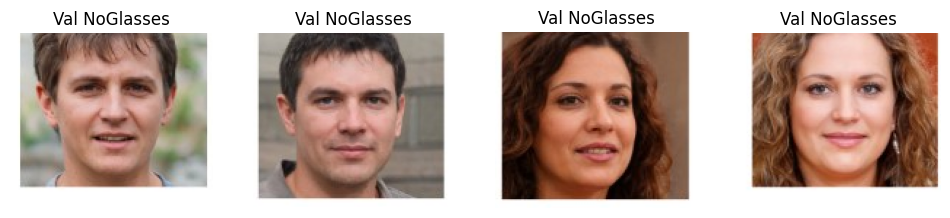

Val NoGlasses 총 이미지 수: 20


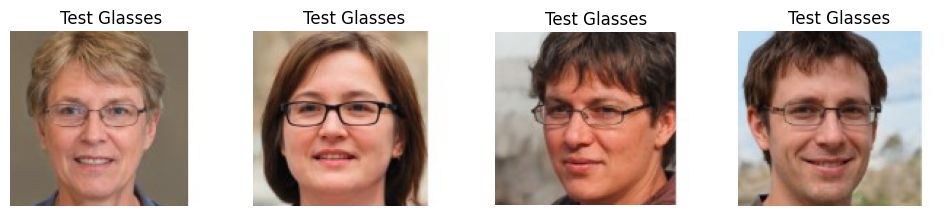

Test Glasses 총 이미지 수: 10


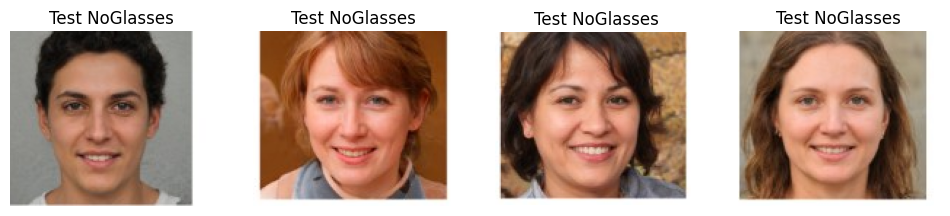

Test NoGlasses 총 이미지 수: 10


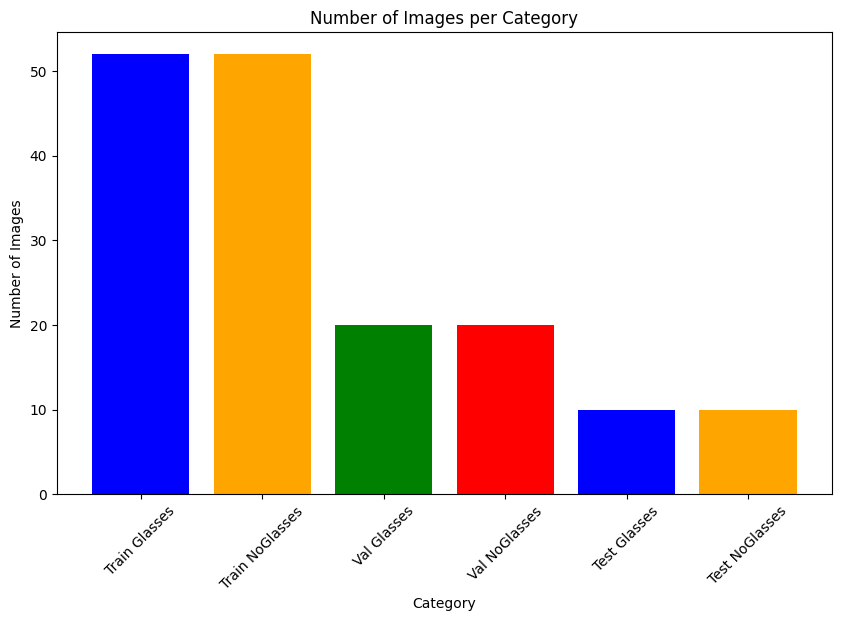

In [9]:
categories = ['Train Glasses', 'Train NoGlasses', 'Val Glasses', 'Val NoGlasses', 'Test Glasses', 'Test NoGlasses']

for category in categories:
    image_paths = glob.glob(f'/Users/taeyoun/Downloads/DeepLearning/project/Chapter 1. Binary Classification _ 두 선택지 중 하나를 선택하여 판별하는 분류 방법/실습 파일/2/{category.lower().replace(" ", "/")}/*')
    display_images_center_crop(image_paths, category)  # 함수 호출 수정
    print(f"{category} 총 이미지 수: {len(image_paths)}")

# 바 그래프 생성
plt.figure(figsize=(10, 6))
plt.bar(categories, [len(glob.glob(f'/Users/taeyoun/Downloads/DeepLearning/project/Chapter 1. Binary Classification _ 두 선택지 중 하나를 선택하여 판별하는 분류 방법/실습 파일/2/{category.lower().replace(" ", "/")}/*')) for category in categories], color=['blue', 'orange', 'green', 'red'])
plt.title('Number of Images per Category')
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

In [25]:
# 데이터 전처리 정의
transform = transforms.Compose([
    transforms.CenterCrop(128),  # 이미지 Crop
    transforms.Resize((224, 224)),  # 이미지 크기 조정
    transforms.RandomHorizontalFlip(),  # 이미지를 무작위로 수평 뒤집기
    transforms.RandomRotation(30),  # 이미지를 최대 30도까지 무작위로 회전
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # 이미지의 밝기, 대비, 채도, 색조를 무작위로 변경
    transforms.RandomGrayscale(p=0.2),  # 20% 확률로 이미지를 그레이스케일로 변환
    transforms.ToTensor(),  # 이미지를 텐서로 변환
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 정규화
])

# 데이터셋 로드 및 데이터 로더 생성
train_dataset = ImageFolder('/Users/taeyoun/Downloads/DeepLearning/project/Chapter 1. Binary Classification _ 두 선택지 중 하나를 선택하여 판별하는 분류 방법/실습 파일/2/train', transform=transform)
val_dataset = ImageFolder('/Users/taeyoun/Downloads/DeepLearning/project/Chapter 1. Binary Classification _ 두 선택지 중 하나를 선택하여 판별하는 분류 방법/실습 파일/2/val', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

In [26]:
import torch.nn as nn
import torch.nn.functional as F

class AlexNet(nn.Module):
    def __init__(self, num_classes = 1000):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0)
        self.conv2 = 

In [27]:
net = AlexNet(num_classes=2)  # 예: 이진 분류 문제의 경우
net = net.to(device)

In [28]:
# 손실 함수 및 최적화기
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

In [29]:
# 정확도 계산 함수
def calculate_accuracy(loader, model):
    """주어진 데이터 로더에 대한 모델의 정확도를 계산합니다."""
    model.eval()  # 모델을 평가 모드로 설정
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total